신경망에서는 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등 하이퍼파라미터가 다수 등장한다. 이러한 하이퍼파라미터의 값을 적절히 설정하지 않으면 모델의 성능이 크게 떨어지기도 한다. 하이퍼파라미터의 값은 매우 중요하지만 그 값을 결정하기까지는 일반적으로 많은 시행착오를 겪는다. 이번 절에서는 하이퍼파라미터의 값을 최대한 효율적으로 탐색하는 방법을 설명한다.

# 6.5.1 검증 데이터

지금까지는 데이터셋을 훈련 데이터와 시험 데이터라는 두 가지로 분리해 이용했다. 훈련 데이터로는 학습을 하고, 시험 데이터로는 범용 성능을 평가했다. 그렇게 해서 훈련 데이터에만 지나치게 적응되어 있지 않은지, 그리고 범용 성능은 어느 정도인지를 평가할 수 있었다. 

앞으로 하이퍼파라미터를 다양한 값으로 설정하고 검증할 텐데, 여기서 주의할 점은 하이퍼파라미터의 성능을 평가할 때는 시험 데이터를 사용해서 안 된다는 것이다. 매우 중요하지만 놓치기 쉬운 포인트다. 

같은 성능 평가인데 하이퍼파라미터가 대상일 때는 시험 데이터를 사용해서는 안 되는 이유는, 하이퍼파라미터의 값이 시험 데이터에 오버피팅되기 때문이다. 

그래서 하이퍼파라미터를 조정할 때는 하이퍼파라미터 전용 확인 데이터가 필요하다. 하이퍼파라미터 조정용 데이터를 일반적으로 "__검증 데이터(validation data)__"라고 부른다. 

일반적으로는 훈련 데이터, 검증 데이터, 시험 데이터를 미리 분리해둔 것도 있지만, 그렇지 않은 것도 있다. 그런 경우에는 사용자가 직접 데이터를 분리해야 한다. 가장 간단하게 검증 데이터를 얻는 방법은 훈련 데이터 중 20%를 검증 데이터로 먼저 분리하는 것이다. 코드로는 다음과 같다.

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from multilayernet import MultiLayerNet
from optimizer import SGD
from source.dataset.mnist import load_mnist
import matplotlib.pyplot as plt

(x_train, t_train), (x_test, t_test) = load_mnist(one_hot_label=True)
x_train, t_train = x_train[:500], t_train[:500]
train_index = np.arange(x_train.shape[0])
np.random.shuffle(train_index)
x_train, t_train = x_train[train_index], t_train[train_index]

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

이 코드는 훈련 데이터를 분리하기 전에 입력 데이터와 정답 레이블을 뒤섞는다. 데이터 셋 안의 데이터가 치우쳐 있을지도 모르기 때문이다.

# 6.5.2 하이퍼파라미터 최적화

하이퍼파라미터를 최적화할 때의 핵심은 하이퍼파라미터의 "최적 값"이 존재하는 범위를 조금씩 줄여가는 것이다. 범위를 조금씩 줄이려면 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸(샘플링) 후, 그 값으로 정확도를 평가한다.

하이퍼파라미터의 범위는 "대략적으로" 지정하는 것이 효과적이다. 실제로도 0.001에서 1,000사이와 같이 "10의 거듭제곱"단위로 범위를 지정한다. 이를 "로그 스케일(log scale)로 지정"한다고 한다.

하이퍼파라미터를 최적화할 때는 딥러닝 학습에는 오랜 시간(예컨대 며칠이나 몇 주 이상)이 걸린다는 점을 기억해야 한다. 따라서 나쁠 듯한 값은 일찍 포기하는 게 좋다. 그렇게 학습을 위한 에폭을 작게하여, 1회 평가에 걸리는 시간을 단축하는 것이  효과적이다.

지금 까지의 이야기를 정리하면 다음과 같다.
* 0단계
    * 하이퍼파라미터 값의 범위를 설정한다.
* 1단계
    * 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출한다.
* 2단계
    * 1단계에서 샘플링한 하이퍼파라미터의 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다.(단, 에폭은 작게 설정)
* 3단계
    * 1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

이런 방법으로 하이퍼파라미터의 범위를 좁혀나가며 최종적으로 하이퍼파라미터의 값을 결정한다.

# 6.5.3 하이퍼파라미터 최적화 구현하기

MNIST 데이터 셋을 이용하여 하이퍼파라미터를 최적화 해보자. 여기에서는 학습률과 가중치 감소의 세기를 조절하는 계수(가중치 감소 계수)를 탐색하는 문제를 해결해보자.

앞에서 말한 대로, 하이퍼파라미터의 검증은 그 값을 0.001~1,000 사이 가은 로그 스케일 범위에서 무작위로 추출해 수행한다. 이 예에서는 가중치 감소 계수를 $10^{-8}\sim10^{-4}$, 학습률을 $10^{-6}\sim10^{-2}$범위부터 시작한다. 이 경우 하이퍼파라미터의 무작위 추출 코드는 다음과 같이 쓸 수 있다.

In [3]:
from trainer import Trainer

train_result = {}
val_result = {}

for n in range(100):
    wd = 10 ** np.random.uniform(-8,-4)
    lr = 10 ** np.random.uniform(-6,-2)
    
    training = Trainer(lr, wd, x_train, t_train, x_val, t_val)
    train_acc_list, val_acc_list = training.train()
    
    key = f"wd: {wd}, lr: {lr}"
    train_result[key] = train_acc_list
    val_result[key] = val_acc_list

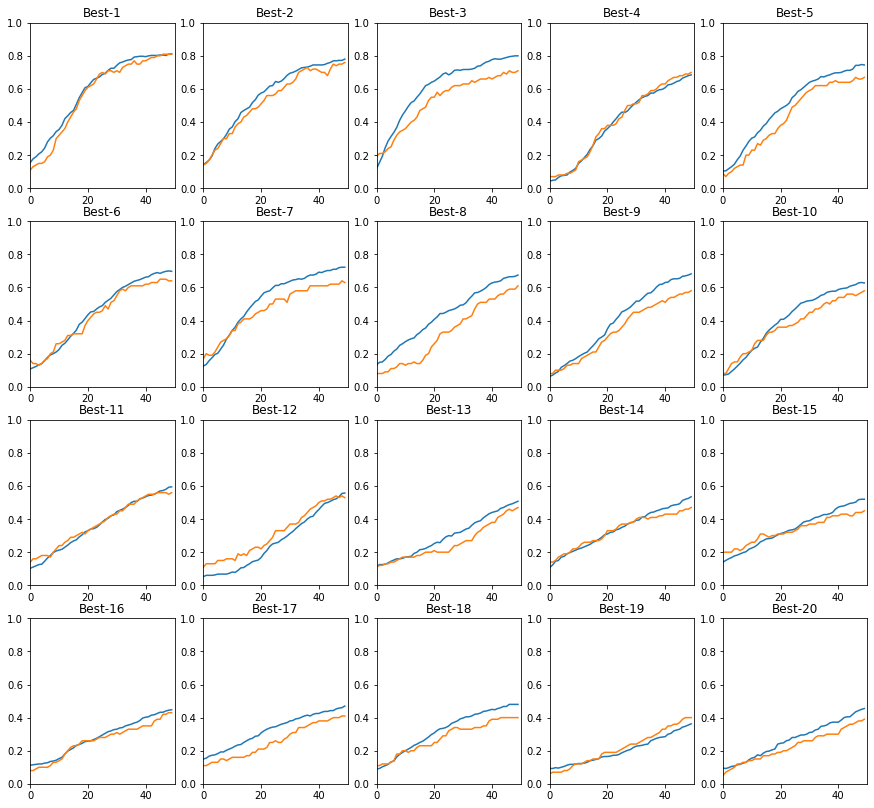

In [25]:
keys = list()
train_values = list()
val_values = list()
epochs = np.arange(50)

for key, value in sorted(val_result.items(), key=lambda x : x[1][-1], reverse=True):
    keys.append(key)
    val_values.append(value)
    train_values.append(train_result[key])
    
plt.figure(figsize=(15,14))
## best 20 
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(epochs, train_values[i])
    plt.plot(epochs, val_values[i])
    plt.title(f"Best-{i+1}")
    plt.xlim(0,50)
    plt.ylim(0.0,1.0)
plt.show()

이 결과는 2층 신경망을 통해 계산한 결과이고, 다음은 7층 신경망을 통해 계산한 결과와 유사한 이미지를 가져온 것이다.

<img src=images/6_24.png height=100px width=500px>

위 그림은 검증 데이터의 학습 추이를 정확도가 높은 순서로 나열하였다. 이를 보면 "Best-5"정도까지는 학습이 순조롭게 진행되고 있다. 이를 바탕으로 "Best-5"까지의 하이퍼파라미터의 값을 살펴보자.

In [24]:
for i in range(5):
    print(f"Best-{i+1} (val acc:{val_values[i][-1]}) | {keys[i]}")

Best-1 (val acc:0.81) | wd: 1.938176111434114e-08, lr: 0.008941441162671027
Best-2 (val acc:0.76) | wd: 1.9126296823073417e-05, lr: 0.006529611366359764
Best-3 (val acc:0.71) | wd: 4.865138658059046e-06, lr: 0.006568063371109372
Best-4 (val acc:0.7) | wd: 5.0311957751137546e-05, lr: 0.003451773767946098
Best-5 (val acc:0.67) | wd: 1.3868434831416719e-06, lr: 0.006006287936566173


이 결과를 보면 학습이 잘 진행될 때의 학습률은 $0.001\sim0.01$, 가중치 감소계수는 $10^{-8}\sim10^{-5}$정도라는 것을 알 수 있다. 이처럼 잘될 것 같은 값의 범위를 관찰하고 범위를 좁혀간다. 그런 다음 그 축소된 범위로 똑같은 작업을 반복하는 것이다. 이렇게 적절한 값이 위치한 범위를 좁혀가다가 특정 단계에서 최종 하이퍼파라미터의 값을 하나 선택한다.